<a href="https://colab.research.google.com/github/rezamohammadloo/IMDB_CLASSIFICATION/blob/main/IMDB_REVIEW_CLASSIFICATION(LSTM%2C_GRU%2C_1DCONV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing Requiered Packages
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#Downloading and Preparing Dataset
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTEQSHQ/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTEQSHQ/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTEQSHQ/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
#Getting Training and Test set
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [4]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initializing the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generating the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [5]:
# Defining a Functino to Compare Models
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [6]:
#Model1: Flatten
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 4s 14ms/step - loss: 0.6053 - accuracy: 0.6654 - val_loss: 0.3915 - val_accuracy: 0.8333
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.3164 - accuracy: 0.8675 - val_loss: 0.3393 - val_accuracy: 0.8508
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.2000 - accuracy: 0.9298 - val_loss: 0.3521 - val_accuracy: 0.8454
Epoch 4/10
196/196 [==============================] - 2s 8ms/step - loss: 0.1123 - accuracy: 0.9711 - val_loss: 0.3920 - val_accuracy: 0.8381
Epoch 5/10
196/196 [==============================] - 2s 11ms/step - loss: 0.0516 - accuracy: 0.9940 - val_loss: 0.4342 - val_accuracy: 0.8353
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0229 - accuracy: 0.9987 - val_loss: 0.4746 - val_accuracy: 0.8326
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0112 - accuracy: 0.9996 - val_loss: 0.5105 - val_accuracy: 0.8323
E

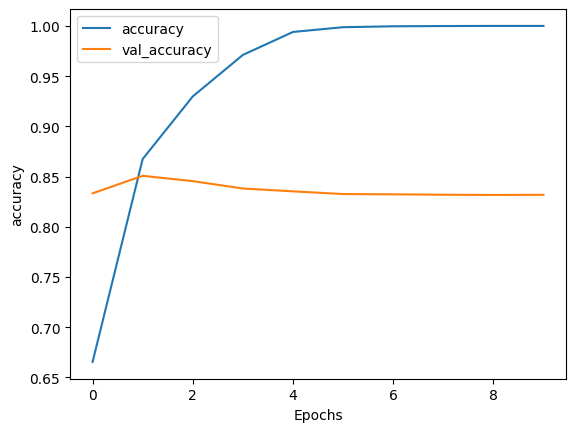

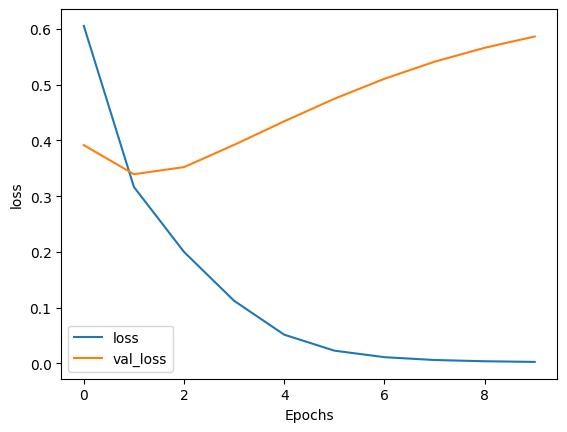

In [8]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

In [9]:
#Model2: LSTM
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172941 (675.55 KB)
Trainable params: 172941 (675.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 40s 183ms/step - loss: 0.5929 - accuracy: 0.6624 - val_loss: 0.4830 - val_accuracy: 0.7830
Epoch 2/10
196/196 [==============================] - 33s 171ms/step - loss: 0.3490 - accuracy: 0.8548 - val_loss: 0.3484 - val_accuracy: 0.8462
Epoch 3/10
196/196 [==============================] - 35s 179ms/step - loss: 0.2637 - accuracy: 0.8996 - val_loss: 0.3758 - val_accuracy: 0.8416
Epoch 4/10
196/196 [==============================] - 34s 174ms/step - loss: 0.2202 - accuracy: 0.9215 - val_loss: 0.4142 - val_accuracy: 0.8332
Epoch 5/10
196/196 [==============================] - 35s 178ms/step - loss: 0.1903 - accuracy: 0.9340 - val_loss: 0.4473 - val_accuracy: 0.8298
Epoch 6/10
196/196 [==============================] - 34s 174ms/step - loss: 0.1602 - accuracy: 0.9475 - val_loss: 0.4585 - val_accuracy: 0.8254
Epoch 7/10
196/196 [==============================] - 35s 179ms/step - loss: 0.1406 - accuracy: 0.9537 - val_loss: 0.4800 - val_ac

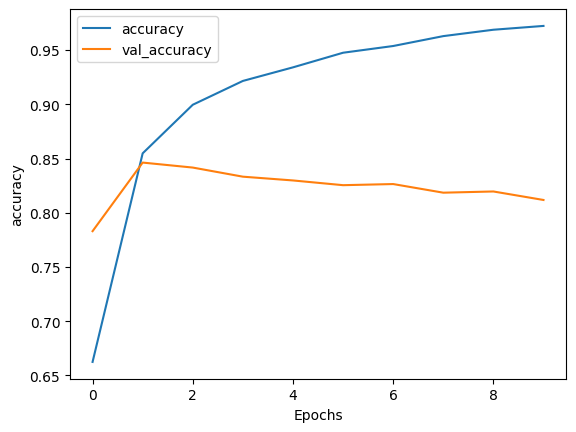

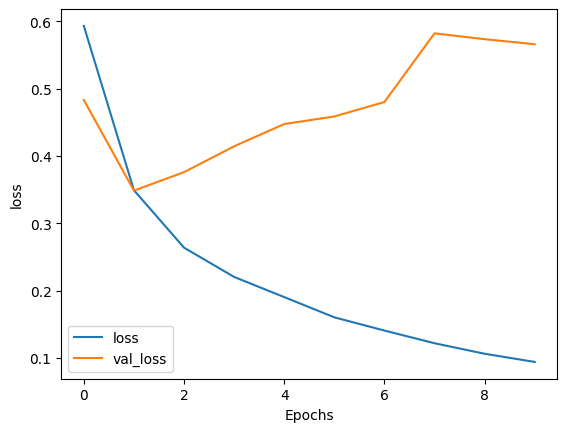

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [12]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169997 (664.05 KB)
Trainable params: 169997 (664.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 42s 191ms/step - loss: 0.6136 - accuracy: 0.6290 - val_loss: 0.3834 - val_accuracy: 0.8366
Epoch 2/10
196/196 [==============================] - 35s 180ms/step - loss: 0.3285 - accuracy: 0.8592 - val_loss: 0.3505 - val_accuracy: 0.8469
Epoch 3/10
196/196 [==============================] - 34s 173ms/step - loss: 0.2485 - accuracy: 0.9017 - val_loss: 0.3688 - val_accuracy: 0.8440
Epoch 4/10
196/196 [==============================] - 38s 196ms/step - loss: 0.1981 - accuracy: 0.9280 - val_loss: 0.4074 - val_accuracy: 0.8330
Epoch 5/10
196/196 [==============================] - 38s 196ms/step - loss: 0.1596 - accuracy: 0.9443 - val_loss: 0.4791 - val_accuracy: 0.8290
Epoch 6/10
196/196 [==============================] - 37s 187ms/step - loss: 0.1305 - accuracy: 0.9562 - val_loss: 0.5331 - val_accuracy: 0.8238
Epoch 7/10
196/196 [==============================] - 33s 170ms/step - loss: 0.0976 - accuracy: 0.9679 - val_loss: 0.5469 - val_ac

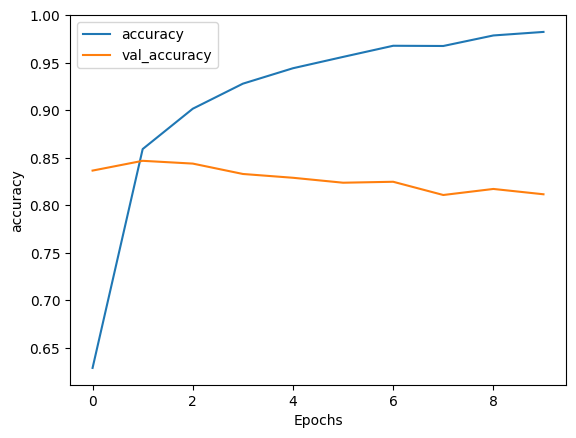

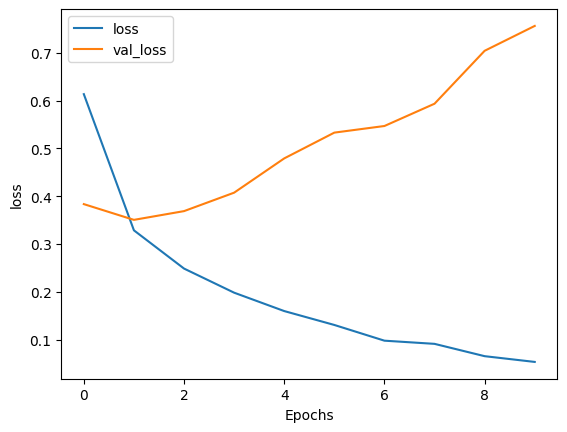

In [14]:
# Plotting the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

In [15]:
#Model4: 1DConvolution
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 10s 46ms/step - loss: 0.5741 - accuracy: 0.6822 - val_loss: 0.3736 - val_accuracy: 0.8381
Epoch 2/10
196/196 [==============================] - 10s 49ms/step - loss: 0.3122 - accuracy: 0.8702 - val_loss: 0.3504 - val_accuracy: 0.8483
Epoch 3/10
196/196 [==============================] - 11s 57ms/step - loss: 0.2473 - accuracy: 0.9019 - val_loss: 0.3890 - val_accuracy: 0.8348
Epoch 4/10
196/196 [==============================] - 12s 62ms/step - loss: 0.2118 - accuracy: 0.9180 - val_loss: 0.3972 - val_accuracy: 0.8399
Epoch 5/10
196/196 [==============================] - 9s 46ms/step - loss: 0.1834 - accuracy: 0.9333 - val_loss: 0.4370 - val_accuracy: 0.8315
Epoch 6/10
196/196 [==============================] - 9s 48ms/step - loss: 0.1619 - accuracy: 0.9422 - val_loss: 0.4945 - val_accuracy: 0.8190
Epoch 7/10
196/196 [==============================] - 10s 49ms/step - loss: 0.1442 - accuracy: 0.9504 - val_loss: 0.5385 - val_accuracy: 0

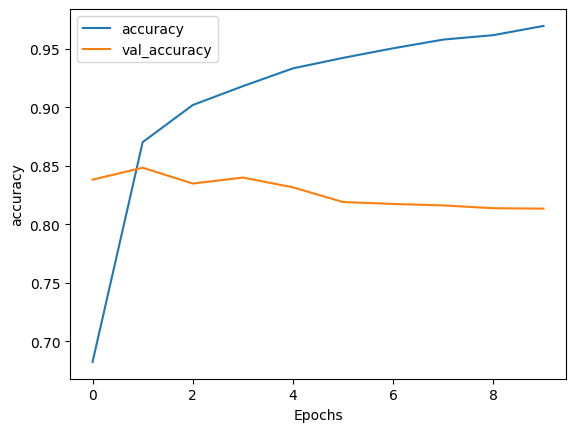

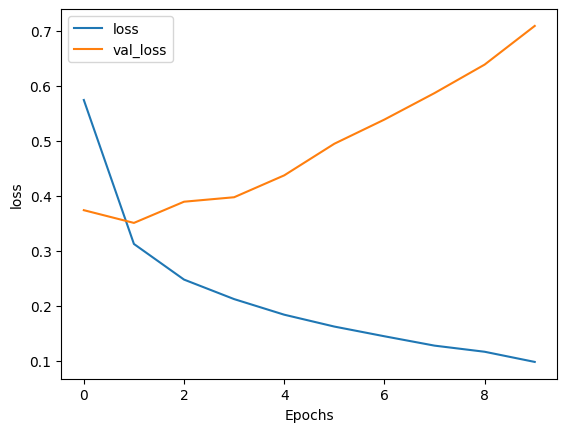

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')